In [ ]:
import os
for dir in ['service', 'data', 'model']:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [ ]:
%%writefile service/utils.py

import os
import random
import numpy as np
import torch

def reset_seeds(func, seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed) # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

  def wrapper_func(*args, **kwargs):
    return func(*args, **kwargs)

  return wrapper_func

Writing service/utils.py


In [ ]:
!pip install optuna
!pip install catboost xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

In [ ]:
from service.utils import reset_seeds

# 데이터 로드

# EDA

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
import numpy as np

- surived:0=사망, 1=생존
- pclass: 1=1등석, 2=2등석, 3=3등석
- name: 이름
- gender:male=남성, female=여성
- age: 나이
- sibSp: 타이타닉 호에 동승한 자매/배우자의 수
- parch: 타이타닉 호에 동승한 부모/자식의 수
- ticket: 티켓 번호
- fare: 승객 요금
- cabin: 방 호수
- embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1806 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  1806 non-null   int64  
 1   survived     1806 non-null   int64  
 2   pclass       1806 non-null   int64  
 3   name         1806 non-null   object 
 4   gender       1806 non-null   object 
 5   age          1449 non-null   float64
 6   sibsp        1806 non-null   int64  
 7   parch        1806 non-null   int64  
 8   ticket       1806 non-null   object 
 9   fare         1806 non-null   float64
 10  cabin        402 non-null    object 
 11  embarked     1803 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 183.4+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  393 non-null    int64  
 1   pclass       393 non-null    int64  
 2   name         393 non-null    object 
 3   gender       393 non-null    object 
 4   age          310 non-null    float64
 5   sibsp        393 non-null    int64  
 6   parch        393 non-null    int64  
 7   ticket       393 non-null    object 
 8   fare         392 non-null    float64
 9   cabin        97 non-null     object 
 10  embarked     392 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 33.9+ KB


In [ ]:
train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


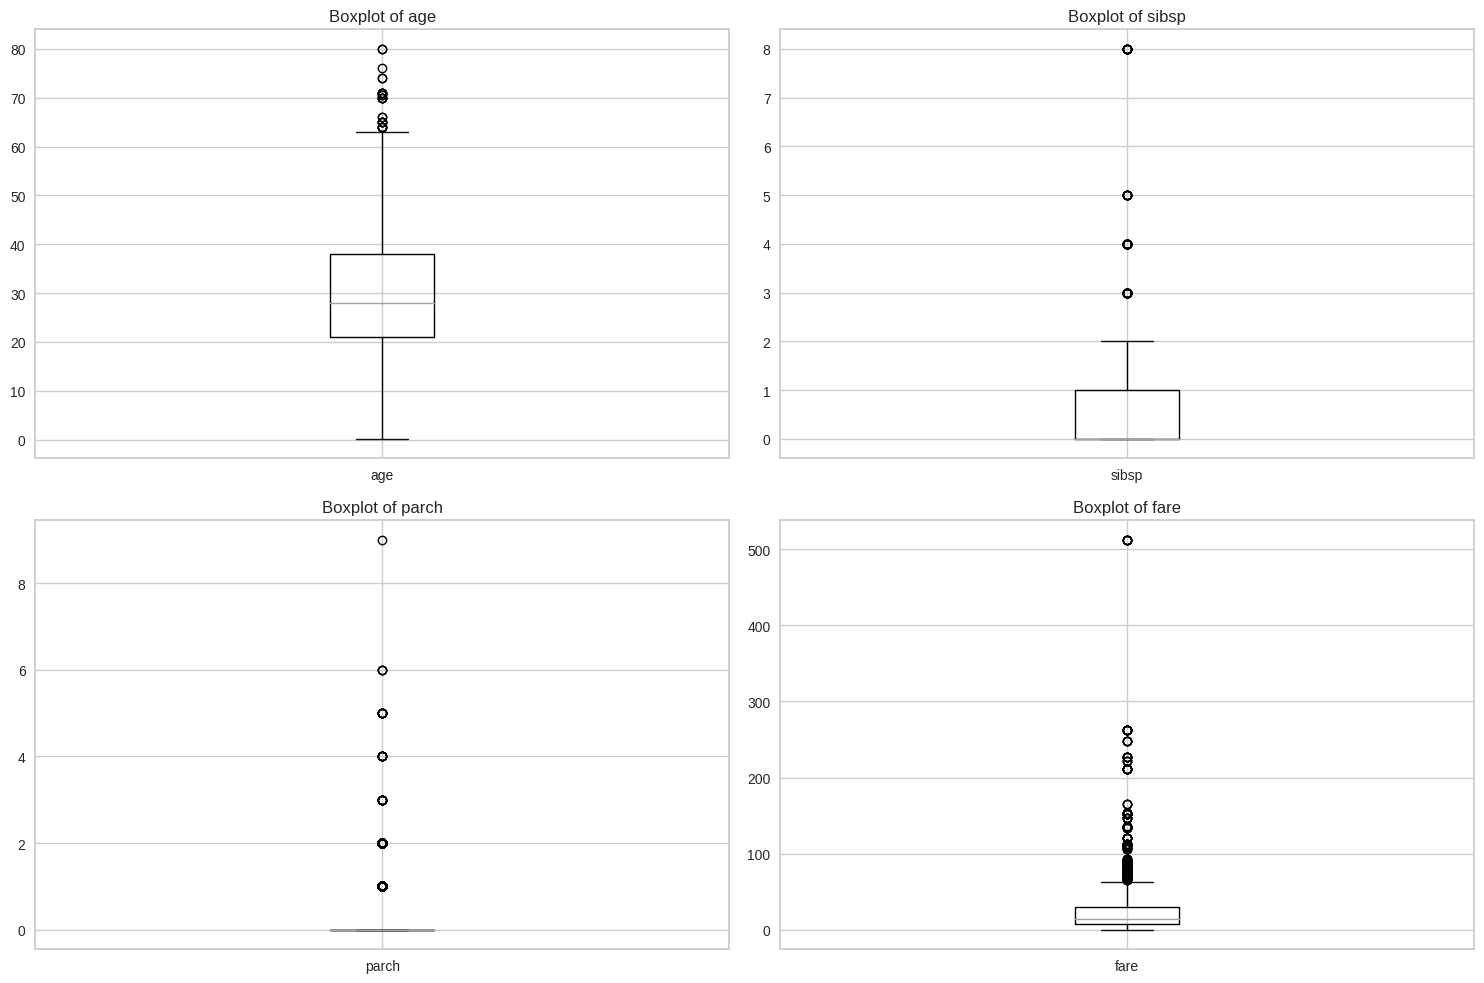

In [ ]:
# 박스 플롯을 통해 이상치를 시각적으로 확인
import matplotlib.pyplot as plt

# 연속형 변수들에 대해 박스 플롯을 그려서 이상치를 확인
numeric_columns = ['age', 'sibsp', 'parch', 'fare']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    train.boxplot(column=col)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [ ]:
# 1. 생존자 수와 사망자 수 시각화
fig1 = px.histogram(train, x='survived', color='survived', title='Survived vs Dead')
fig1.show()

In [ ]:
# 2. Pclass(티켓 등급)와 생존율 시각화
fig2 = px.histogram(train, x='pclass', color='survived', barmode='group', title='Pclass vs Survived')
fig2.show()

In [ ]:
# 3. 성별에 따른 생존율 시각화
fig3 = px.histogram(train, x='gender', color='survived', barmode='group', title='Gender vs Survived')
fig3.show()

In [ ]:
# 4. 나이 분포 시각화 및 생존율 분석
fig4 = px.histogram(train, x='age', color='survived', nbins=30, title='Age Distribution')
fig4.show()

In [ ]:
# 5. 상관관계 히트맵
corr_matrix = train[['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']].corr()
fig6 = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='Viridis'))
fig6.update_layout(title='Feature Correlation Heatmap')
fig6.show()

In [ ]:
# 6. SibSp (형제자매/배우자 수)와 생존율 시각화
fig7 = px.histogram(train, x='sibsp', color='survived', barmode='group', title='SibSp vs Survived')
fig7.show()

In [ ]:
# 7. Parch (부모/자녀 수)와 생존율 시각화
fig8 = px.histogram(train, x='parch', color='survived', barmode='group', title='Parch vs Survived')
fig8.show()

In [ ]:
# 8. Embarked (탑승한 항구)와 생존율 시각화
fig9 = px.histogram(train, x='embarked', color='survived', barmode='group', title='Embarked vs Survived')
fig9.show()

In [ ]:
# 9. Fare (운임 요금) 분포 및 생존율 시각화
fig10 = px.histogram(train, x='fare', nbins=50, title='Fare Distribution')
fig10.show()

In [ ]:
# 요금과 생존 확률
fig11 = go.Figure()
fig11.add_trace(go.Histogram(x=train[train['survived'] == 1]['fare'], nbinsx=50, name='Survived', opacity=0.75))
fig11.add_trace(go.Histogram(x=train[train['survived'] == 0]['fare'], nbinsx=50, name='Not Survived', opacity=0.75))
fig11.update_layout(barmode='overlay', title='Fare vs Survived', xaxis_title='Fare', yaxis_title='Count')
fig11.show()

In [ ]:
fig12 = px.histogram(train, x='cabin', color='survived', barmode='group', title='Cabin vs Survived')
fig12.show()

In [ ]:
# 10. Cabin 정보 분석
# Cabin이 없는 경우와 있는 경우를 비교
train['cabin_known'] = train['cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
fig12 = px.histogram(train, x='cabin_known', color='survived', barmode='group', title='Cabin Known vs Survived')
fig12.show()

In [ ]:
# 이름에서 호칭 추출
train['Title'] = train['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title'] = test['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# 호칭 별 분포 및 생존율 분석
title_counts = train['Title'].value_counts()
title_survived = train.groupby('Title')['survived'].mean()

title_counts, title_survived

(Title
 Mr              528
 Miss            185
 Mrs             138
 Master           42
 Rev               6
 Dr                5
 Col               3
 Major             2
 Don               1
 Ms                1
 Jonkheer          1
 Mlle              1
 the Countess      1
 Capt              1
 Sir               1
 Name: count, dtype: int64,
 Title
 Capt            0.000000
 Col             0.000000
 Don             0.000000
 Dr              0.400000
 Jonkheer        0.000000
 Major           0.500000
 Master          0.285714
 Miss            0.805405
 Mlle            1.000000
 Mr              0.109848
 Mrs             0.869565
 Ms              1.000000
 Rev             0.000000
 Sir             1.000000
 the Countess    1.000000
 Name: survived, dtype: float64)

In [ ]:
# 호칭 별 분포 시각화
fig_title_count = px.bar(title_counts, x=title_counts.index, y=title_counts.values, title='Title Distribution')
fig_title_count.show()

In [ ]:
# 호칭 별 생존율 시각화
fig_title_survived = px.bar(title_survived, x=title_survived.index, y=title_survived.values, title='Survival Rate by Title')
fig_title_survived.show()

In [ ]:
# Top 20 most common tickets
top_tickets = train['ticket'].value_counts().head(20)

# Bar plot for the top 20 most common tickets
fig = px.bar(top_tickets,
             x=top_tickets.index,
             y=top_tickets.values,
             title="Top 20 Most Common Tickets",
             labels={'x':'Ticket', 'y':'Count'})
fig.show()

# 데이터 초기화

In [ ]:
import pandas as pd
import numpy as np

# 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# 'survived'를 타깃 변수로 분리
y = train['survived']
X = train.drop(columns=['survived'])

# Train/Test 데이터셋으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 클리닝

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
import plotly.express as px
import plotly.graph_objs as go
import numpy as np

In [ ]:
dict_initial_name = {
'Mr': 'Others',
'Miss': 'Others',
'Mrs': 'Others',

'Master': 'Officer',
'Dr': 'Officer',
'Rev': 'Officer',
'Col': 'Officer',
'Major': 'Officer',
'Capt': 'Officer',

'Jonkheer': 'Royalty',
'Countess': 'Royalty',
'Sir': 'Royalty'
}
def add_initial_name_type(initial_name):
  result = 'Others'
  try:
    result = dict_initial_name[initial_name]
  except:
    pass
  return result

In [ ]:
@reset_seeds
def clean_data(df):
    """
    주어진 데이터프레임을 클리닝하는 함수.
    - 결측치 처리
    - 이상치 처리
    - 불필요한 칼럼 제거
    - 호칭 추출 및 처리

    Parameters:
    df (pd.DataFrame): 원본 데이터프레임

    Returns:
    pd.DataFrame: 클리닝된 데이터프레임
    """

    # 이름에서 호칭(title) 추출
    df['title'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Initial_name_type'] = df['title'].map(lambda x: add_initial_name_type(x))

    # cabin: 'unknown'으로 대체
    df['cabin'].fillna('unknown', inplace=True)

    # age: title별로 중간값으로 대체 (transform을 사용하여 인덱스 문제 해결)
    df['age'] = df.groupby('title')['age'].transform(lambda x: x.fillna(x.median()))
    # age: 중간값으로 대체 (transform을 사용하여 인덱스 문제 해결)
    df['age'].fillna(df['age'].median(), inplace=True)
    # fare: 중간값으로 대체
    df['fare'].fillna(df['fare'].median(), inplace=True)
    # embarked: 가장 빈번한 값인 's'로 대체
    embarked_imputer = SimpleImputer(strategy='most_frequent')
    df['embarked'] = embarked_imputer.fit_transform(df[['embarked']]).ravel()

    # 'fare' 값이 500이 넘는 경우를 300 이하에서 가장 높은 값으로 변환
    max_fare_below_300 = df[df['fare'] <= 300]['fare'].max()
    df.loc[df['fare'] > 500, 'fare'] = max_fare_below_300

    return df

In [ ]:
# 데이터 클리닝 함수 적용
X_train_cleaned = clean_data(X_train)
X_test_cleaned = clean_data(X_test)
test_cleaned = clean_data(test)
ttrain_cleaned = clean_data(train)

# 결과 확인
X_train_cleaned.head()

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,...,gender_age_bins,gender_fare_bin,shared_ticket_count,shared_ticket_group,ticket_prefix,has_ticket_prefix,has_cabin,is_southampton_embarked,len_ticket,cabin_is_shared
900,900,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,unknown,...,male_young_adult,male_0,2,group_2_3,SOTON/OQ,prefix,0,1,2,True
883,884,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,unknown,...,male_young_adult,male_1,2,group_2_3,C.A./SOTON,prefix,0,1,2,True
212,213,3,"Perkin, Mr. John Henry",male,22.0,0,0,A/5 21174,7.2500,unknown,...,male_young_adult,male_0,1,group_1,A/5,prefix,0,1,2,True
48,49,3,"Samaan, Mr. Youssef",male,29.0,2,0,2662,21.6792,unknown,...,male_young_adult,male_2,1,group_1,none,none,0,0,1,True
394,394,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,34218,10.5000,E101,...,female_young_adult,female_1,2,group_2_3,none,none,1,1,1,True


In [ ]:
# # 박스 플롯을 통해 이상치를 시각적으로 확인
# import matplotlib.pyplot as plt

# # 연속형 변수들에 대해 박스 플롯을 그려서 이상치를 확인
# numeric_columns = ['age', 'sibsp', 'parch', 'fare']

# plt.figure(figsize=(15, 10))
# for i, col in enumerate(numeric_columns, 1):
#     plt.subplot(2, 2, i)
#     X_train_cleaned.boxplot(column=col)
#     plt.title(f'Boxplot of {col}')

# plt.tight_layout()
# plt.show()

In [ ]:
# fig = px.histogram(train, x='age', color='survived', barmode='group', title='Gender vs Survived')
# fig.show()

# 피처 엔지니어링

In [ ]:
def feature_engineering(df):
    """
    주어진 데이터프레임에 대해 피처 엔지니어링을 수행하는 함수.
    - family_size, is_alone, fare_per_person, deck, age_bins, pclass_age, pclass_fare, shared_ticket_count, ticket_prefix, has_cabin, embarked_fare_median, is_child 등의 새로운 피처를 생성

    Parameters:
    df (pd.DataFrame): 원본 데이터프레임

    Returns:
    pd.DataFrame: 피처 엔지니어링이 완료된 데이터프레임
    """

    # 1. 가족 크기(family_size) 변수 생성
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_small_family'] = ((df['family_size'] >= 2) & (df['family_size'] <= 4)).astype(int)
    df['family_size_category'] = pd.cut(df['family_size'], bins=[0, 1, 4, df['family_size'].max()], labels=['Alone', 'Small', 'Large'])

    # 2. IsAlone 변수 생성
    df['is_alone'] = (df['family_size'] == 1).astype(int)

    # 3. Fare 변수 생성
    df['fare_per_person'] = df['fare'] / df['family_size']
    df['fare_bin'] = pd.qcut(df['fare'], 4, labels=False)

    # 4. Deck 변수 생성
    # df['deck'] = df['cabin'].apply(lambda x: x[0].upper() if pd.notna(x) and x != 'unknown' else 'unknown')

    # 5. Age Binning (나이 구간화)
    df['age_bins'] = pd.cut(df['age'],
                        bins=[0, 4, 12, 19, 35, 60, np.inf],
                        labels=['infant', 'child', 'teen', 'young_adult', 'middle_aged', 'senior'])
    # df['age_bin_interaction'] = df['age_bins'].astype(str) + '_' + df['pclass'].astype(str)




    # del Shared Ticket Count 변수 생성
    df['shared_ticket_count'] = df.groupby('ticket')['ticket'].transform('count')
    # 2, 3인 경우와 4, 5, 6, 7인 경우를 묶어서 새로운 피처 생성
    df['shared_ticket_group'] = df['shared_ticket_count'].apply(
    lambda x: 'group_1' if x == 1 else 'group_2_3' if x in [2, 3] else 'group_4_plus'
    )
    # del Ticket Prefix (티켓 접두사) 변수 생성
    df['ticket_prefix'] = df['ticket'].apply(lambda x: x.split()[0] if not x.isdigit() else 'none')

    # 'none'인 경우와 아닌 경우를 구분하는 새로운 피처 생성
    df['has_ticket_prefix'] = df['ticket_prefix'].apply(lambda x: 'none' if x == 'none' else 'prefix')

    # 9. Has_Cabin (Cabin 정보 유무) 변수 생성
    df['has_cabin'] = df['cabin'].apply(lambda x: 0 if x == 'unknown' else 1)

    # 10. Embarked Fare Median (탑승 항구 별 운임 중간값) 변수 생성
    df['is_southampton_embarked'] = (df['embarked'] == 'S').astype(int)
    # df['embarked_class_interaction'] = df['embarked'].astype(str) + '_' + df['pclass'].astype(str)

    # 11. 티켓 길이
    df['len_ticket'] = df['ticket'].map(lambda x: len(x.strip().split(' ')))
    df['cabin_is_shared'] = df.groupby('cabin')['cabin'].transform('count') > 1

    # 6. Pclass*Age 및 Pclass*Fare 변수 생성
    df['pclass_age_bins'] = df['pclass'].astype(str) + '_' + df['age_bins'].astype(str)
    df['pclass_fare_bin'] = df['pclass'].astype(str) + '_' + df['fare_bin'].astype(str)
    df['gender_pclass'] = df['gender'].astype(str) + '_' + df['pclass'].astype(str)
    df['gender_age_bins'] = df['gender'].astype(str) + '_' + df['age_bins'].astype(str)
    df['gender_fare_bin'] = df['gender'].astype(str) + '_' + df['fare_bin'].astype(str)
    df['gender_len_ticket'] = df['gender'].astype(str) + '_' + df['fare_bin'].astype(str)
    df['gender_cabin_is_shared'] = df['gender'].astype(str) + '_' + df['fare_bin'].astype(str)
    df['gender_ticket_prefix'] = df['gender'].astype(str) + '_' + df['fare_bin'].astype(str)

    df = df.drop(columns=['passengerid', 'name', 'title', 'embarked', 'fare', 'age', 'family_size',
                          'age_bins', 'fare_bin',
                          'ticket', 'cabin', 'shared_ticket_count', 'ticket_prefix'])

    return df

In [ ]:
# 피처 엔지니어링 함수 적용
X_train_engineered = feature_engineering(X_train_cleaned)
X_test_engineered = feature_engineering(X_test_cleaned)
test_engineered = feature_engineering(test_cleaned)
ttrain = feature_engineering(ttrain_cleaned)

In [ ]:
X_train_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 25 to 102
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   pclass                   732 non-null    int64   
 1   gender                   732 non-null    object  
 2   sibsp                    732 non-null    int64   
 3   parch                    732 non-null    int64   
 4   Initial_name_type        732 non-null    object  
 5   family_size_category     732 non-null    category
 6   is_alone                 732 non-null    int64   
 7   fare_per_person          732 non-null    float64 
 8   gender_pclass            732 non-null    object  
 9   gender_age_bins          732 non-null    object  
 10  gender_fare_bin          732 non-null    object  
 11  shared_ticket_group      732 non-null    object  
 12  has_ticket_prefix        732 non-null    object  
 13  has_cabin                732 non-null    int64   
 14  is_southampton

In [ ]:
fig = px.histogram(ttrain, x='cabin_is_shared', color='survived', barmode="group", title='Survived vs Dead')
fig.show()

# 데이터 스케일링 및 변환

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np

In [ ]:
@reset_seeds
def scale_and_transform_data(train_df, test_df):
    """
    주어진 데이터프레임을 스케일링하고 범주형 변수를 변환하는 함수.
    - 연속형 변수 스케일링
    - 범주형 변수 인코딩
    - 다항식 피처 생성

    Parameters:
    train_df (pd.DataFrame): 훈련 데이터프레임
    test_df (pd.DataFrame): 테스트 데이터프레임

    Returns:
    pd.DataFrame, pd.DataFrame: 스케일링 및 변환된 훈련 및 테스트 데이터프레임
    """

    # 수치형 변수와 범주형 변수를 자동으로 구별
    continuous_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # 다항식 피처 생성기 설정 (degree=2)
    poly_transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

    # ColumnTransformer를 사용하여 연속형 변수 스케일링, 다항식 변환 및 범주형 변수 인코딩
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), continuous_features),
            ('poly', poly_transformer, continuous_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
        ]  # 나머지 칼럼을 그대로 유지
    )

    # 훈련 데이터에 맞춰 fit하고 동일한 변환을 테스트 데이터에 적용
    train_processed = preprocessor.fit_transform(train_df)
    test_processed = preprocessor.transform(test_df)

    # 칼럼명 처리: 공백을 언더스코어로 치환
    feature_names = preprocessor.get_feature_names_out()
    feature_names = [name.replace(" ", "_") for name in feature_names]

    # 변환된 데이터프레임 반환
    return pd.DataFrame(train_processed, columns=feature_names), \
           pd.DataFrame(test_processed, columns=feature_names)


In [ ]:
# 전체 데이터 처리 및 스케일링 과정
@reset_seeds
def process_and_scale_data(X_train, X_test):
    # 데이터 클리닝 함수 적용
    X_train_cleaned = clean_data(X_train)
    X_test_cleaned = clean_data(X_test)

    # 피처 엔지니어링 함수 적용
    X_train_engineered = feature_engineering(X_train_cleaned)
    X_test_engineered = feature_engineering(X_test_cleaned)

    # 스케일링 및 트랜스포밍 함수 적용 (다항식 피처 생성 포함)
    X_train_scaled, X_test_scaled = scale_and_transform_data(X_train_engineered, X_test_engineered)

    return X_train_scaled, X_test_scaled

In [ ]:
# 데이터 처리 및 스케일링 실행
X_train_scaled, X_test_scaled = process_and_scale_data(X_train, X_test)
X_scaled, test_scaled = process_and_scale_data(X, test)

In [ ]:
X_scaled, test_scaled = process_and_scale_data(X, test)

In [ ]:
X_train_scaled.shape, X_test_scaled.shape, X_scaled.shape

((732, 39), (184, 39), (916, 39))

# 중복제거

In [ ]:
# 중복된 칼럼명 확인 함수
def check_duplicate_columns(df):
    """
    데이터프레임에서 중복된 칼럼명을 확인하고 중복된 칼럼명을 반환하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임

    Returns:
    list: 중복된 칼럼명의 리스트
    """
    duplicates = df.columns[df.columns.duplicated()].tolist()
    if duplicates:
        print(f"중복된 칼럼명: {duplicates}")
    else:
        print("중복된 칼럼명이 없습니다.")
    return duplicates

# 데이터프레임에서 중복된 칼럼명 확인
duplicate_columns = check_duplicate_columns(X_train_scaled)
duplicate_columns = check_duplicate_columns(X_test_scaled)
duplicate_columns = check_duplicate_columns(test_scaled)

NameError: name 'X_train_scaled' is not defined

In [ ]:
# 중복된 칼럼 삭제 함수
def remove_duplicate_columns(df):
    """
    데이터프레임에서 중복된 칼럼명을 제거하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임

    Returns:
    pd.DataFrame: 중복된 칼럼이 제거된 데이터프레임
    """
    duplicates = check_duplicate_columns(df)
    if duplicates:
        df = df.loc[:, ~df.columns.duplicated()]
        print(f"중복된 칼럼이 제거되었습니다. 제거된 칼럼: {duplicates}")
    return df

# 데이터프레임에서 중복된 칼럼명 확인 및 제거
X_train_scaled = remove_duplicate_columns(X_train_scaled)
X_test_scaled = remove_duplicate_columns(X_test_scaled)
test_scaled = remove_duplicate_columns(test_scaled)

중복된 칼럼명이 없습니다.
중복된 칼럼명이 없습니다.
중복된 칼럼명이 없습니다.


In [ ]:
# 결과 확인
print("Train shape after removing duplicates:", X_train_scaled.shape)
print("Test shape after removing duplicates:", X_test_scaled.shape)
print("test shape after removing duplicates:", test_scaled.shape)

Train shape after removing duplicates: (732, 39)
Test shape after removing duplicates: (184, 39)
test shape after removing duplicates: (393, 39)


In [ ]:
# # CSV 파일로 저장
# X_train_scaled.to_csv('X_train_scaled.csv', index=False)
# X_test_scaled.to_csv('X_test_scaled.csv', index=False)
# test_scaled.to_csv('test_scaled.csv', index=False)

In [ ]:
print(X_train_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   num__pclass                              732 non-null    float64
 1   num__sibsp                               732 non-null    float64
 2   num__parch                               732 non-null    float64
 3   num__is_alone                            732 non-null    float64
 4   num__fare_per_person                     732 non-null    float64
 5   num__has_cabin                           732 non-null    float64
 6   num__is_southampton_embarked             732 non-null    float64
 7   num__len_ticket                          732 non-null    float64
 8   cat__gender_male                         732 non-null    float64
 9   cat__Initial_name_type_Others            732 non-null    float64
 10  cat__Initial_name_type_Royalty           732 non-n

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_train_scaled.shape, y_train.shape

((732, 39), (732,))

In [ ]:
# 4. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

In [ ]:
X_train_smote.shape, y_train_smote.shape

((912, 39), (912,))

In [ ]:
X_smote.shape, y_smote.shape

((1140, 39), (1140,))

In [ ]:
X_train_smote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   num__pclass                              912 non-null    float64
 1   num__sibsp                               912 non-null    float64
 2   num__parch                               912 non-null    float64
 3   num__is_alone                            912 non-null    float64
 4   num__fare_per_person                     912 non-null    float64
 5   num__has_cabin                           912 non-null    float64
 6   num__is_southampton_embarked             912 non-null    float64
 7   num__len_ticket                          912 non-null    float64
 8   cat__gender_male                         912 non-null    float64
 9   cat__Initial_name_type_Others            912 non-null    float64
 10  cat__Initial_name_type_Royalty           912 non-n

# 피처 선택

In [ ]:
# train = pd.read_csv('./data/train.csv')
train_df = pd.read_csv('./data/train.csv')
train_kaggle_df = pd.read_csv('./data/train_kaggle.csv')
train_kaggle_df.columns = train_kaggle_df.columns.str.lower().str.replace('sex', 'gender')

train = pd.concat([train_df, train_kaggle_df]).drop_duplicates()
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/submission.csv")

# 'survived'를 타깃 변수로 분리
y = train['survived']
X = train.drop(columns=['survived'])

# Train/Test 데이터셋으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 처리 및 스케일링 실행
X_train_scaled, X_test_scaled = process_and_scale_data(X_train, X_test)
X_scaled, test_scaled = process_and_scale_data(X, test)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
X_train_smote.shape, y_train_smote.shape

((1796, 142), (1796,))

In [ ]:
X_smote.shape, y_smote.shape

((2236, 142), (2236,))

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import xgboost as xgb
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import Ridge

In [ ]:
@reset_seeds
def select_important_features(X, y, threshold=0.01):
    """
    랜덤 포레스트를 사용하여 피처 중요도를 계산하고, 중요도가 낮은 피처를 제거하는 함수.

    Parameters:
    X (pd.DataFrame): 설명 변수 데이터프레임
    y (pd.Series): 타깃 변수
    threshold (float): 중요도 임계값. 이 값보다 낮은 피처는 제거됩니다.

    Returns:
    pd.DataFrame: 중요도가 높은 피처만 남긴 데이터프레임
    list: 선택된 중요한 피처의 이름 목록
    """
    # CatBoostClassifier
    model = CatBoostClassifier(random_state=42, verbose=0)
    # model = lgb.LGBMClassifier(random_state=42)
    model.fit(X, y)

    # 피처 중요도 계산
    feature_importances = model.feature_importances_

    # 피처 중요도를 시각화
    feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

    # fig = px.bar(
    #     feature_importances_df,
    #     x='Importance',
    #     y='Feature',
    #     orientation='h',
    #     title='Feature Importances',
    #     width=800,
    #     height=600
    # )
    # fig.show()

    # 중요도가 임계값보다 높은 피처만 선택
    important_features = feature_importances_df[feature_importances_df['Importance'] > threshold]['Feature'].tolist()
    X_selected = X[important_features]

    return X_selected, important_features

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

@reset_seeds
def evaluate_thresholds(X, y, thresholds):
    """
    여러 임계값을 사용하여 피처 중요도를 기반으로 피처를 선택하고, 교차 검증을 통해 성능을 평가하는 함수.

    Parameters:
    X (pd.DataFrame): 설명 변수 데이터프레임
    y (pd.Series): 타깃 변수
    thresholds (list of float): 테스트할 임계값 목록

    Returns:
    dict: 각 임계값에 대한 교차 검증 성능 결과
    """
    results = {}
    model = RandomForestClassifier(random_state=42)

    for threshold in thresholds:
        X_selected, _ = select_important_features(X, y, threshold=threshold)
        scores = cross_val_score(model, X_selected, y, cv=10, scoring='accuracy')
        results[threshold] = np.mean(scores)

    return results

In [ ]:
# 테스트할 임계값 목록
thresholds = [0.005, 0.0075, 0.01, 0.015, 0.02]

# 각 임계값에 대한 성능 평가
results = evaluate_thresholds(X_train_smote, y_train_smote, thresholds)

# 결과 출력
for threshold, score in results.items():
    print(f"Threshold: {threshold}, Cross-Validation Accuracy: {score:.8f}")

# 최적의 임계값 선택
best_threshold = max(results, key=results.get)
print(f"Best threshold: {best_threshold}")

Threshold: 0.005, Cross-Validation Accuracy: 0.91431409
Threshold: 0.0075, Cross-Validation Accuracy: 0.91431409
Threshold: 0.01, Cross-Validation Accuracy: 0.91431409
Threshold: 0.015, Cross-Validation Accuracy: 0.91653942
Threshold: 0.02, Cross-Validation Accuracy: 0.91820919
Best threshold: 0.02


In [ ]:
# 타깃 변수 (y_train)를 가지고 피처 중요도 기반 피처 선택 수행
X_train_selected, important_features = select_important_features(X_train_smote, y_train_smote, 0.02)

# 테스트 데이터셋에도 동일한 피처 선택 적용
X_test_selected = X_test_scaled[important_features]

# 오리지날 테스트 데이터셋에도 동일한 피처 선택 적용
test_selected = test_scaled[important_features]
X_selected = X_smote[important_features]

In [ ]:
X_train_selected.shape

(1796, 133)

In [ ]:
X_selected.shape

(2236, 133)

# 오토 ML

In [ ]:
# !pip install pycaret[full]

In [ ]:
from pycaret.classification import *

exp_clf = setup(data = X_train_selected, target = y_train_smote, session_id=123)

,Description,Value
0,Session id,123
1,Target,survived
2,Target type,Binary
3,Original data shape,"(1796, 134)"
4,Transformed data shape,"(1796, 134)"
5,Transformed train set shape,"(1257, 134)"
6,Transformed test set shape,"(539, 134)"
7,Numeric features,133
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models() # Standard

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,03:32:07
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8926,0.9442,0.8855,0.8996,0.8921,0.7852,0.7860,0.3830
dt,Decision Tree Classifier,0.8791,0.9000,0.8648,0.8910,0.8772,0.7582,0.7592,0.0730
ada,Ada Boost Classifier,0.8346,0.9083,0.8314,0.8387,0.8343,0.6691,0.6703,0.3710
ridge,Ridge Classifier,0.8338,0.9031,0.8266,0.8431,0.8333,0.6675,0.6700,0.0620
lr,Logistic Regression,0.8186,0.8919,0.7901,0.8416,0.8135,0.6372,0.6405,1.1280
knn,K Neighbors Classifier,0.8011,0.8616,0.8394,0.7811,0.8087,0.6023,0.6048,0.0730
nb,Naive Bayes,0.7717,0.8517,0.7218,0.8056,0.7592,0.5435,0.5488,0.0640
svm,SVM - Linear Kernel,0.6023,0.6802,0.6807,0.5665,0.5917,0.2056,0.2316,0.0670
qda,Quadratic Discriminant Analysis,0.5171,0.7463,1.0000,0.5089,0.6746,0.0335,0.1221,0.1300


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

KeyboardInterrupt: 

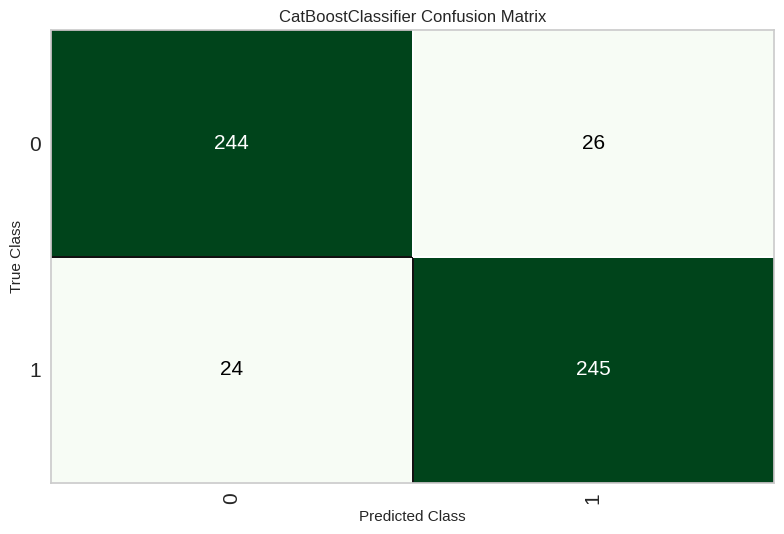

In [ ]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

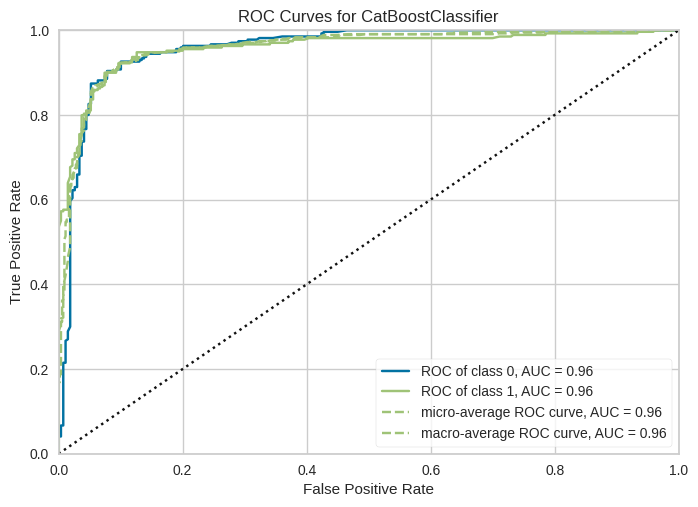

In [ ]:
# plot AUC
plot_model(best_model, plot = 'auc')

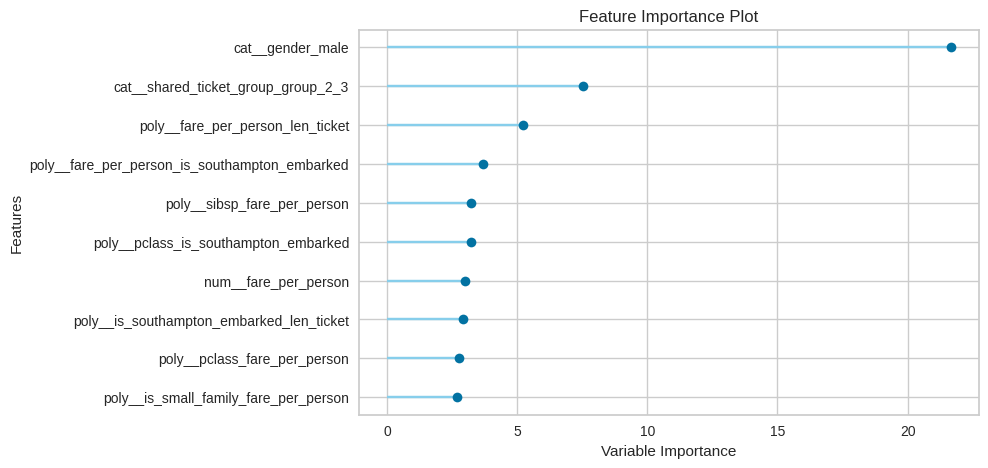

In [ ]:
# plot feature importance
plot_model(best_model, plot = 'feature')

# 차원축소

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 계산
correlation_matrix = X_train_selected.corr()

# 상관관계 히트맵 시각화 (Plotly 사용)
fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='Viridis',
        zmin=-1, zmax=1,
        colorbar=dict(title="Correlation"),
))

fig.update_layout(title='Feature Correlation Matrix',
                  xaxis_nticks=36)

fig.show()

In [ ]:
# # PCA 모델 초기화 (설명된 분산의 95%를 유지하도록 구성)
# pca = PCA(n_components=130, random_state=42)
# X_train_pca = pca.fit_transform(X_train_selected)
# X_test_pca = pca.fit_transform(X_test_selected)
# test_pca = pca.fit_transform(test_selected)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# 상관관계 계산
correlation_matrix = X_train_selected.corr()
correlation_matrix2 = X_selected.corr()

threshold = 0.999
high_corr_features = set()

for i in range(len(correlation_matrix2.columns)):
    for j in range(i):
        if abs(correlation_matrix2.iloc[i, j]) > threshold:
            colname = correlation_matrix2.columns[i]
            high_corr_features.add(colname)

# 상관관계가 높은 피처 제거
X_train_selected_reduced = X_train_selected.drop(columns=high_corr_features)
X_test_selected_reduced = X_test_selected.drop(columns=high_corr_features)
X_selected_reduced = X_selected.drop(columns=high_corr_features)
test_selected_reduced = test_selected.drop(columns=high_corr_features)

KeyError: "['poly__is_alone', 'num__is_small_family', 'poly__sibsp', 'poly__is_alone^2', 'cat__gender_ticket_prefix_female_1', 'cat__gender_ticket_prefix_female_2', 'num__parch', 'num__has_cabin', 'cat__gender_fare_bin_male_0', 'cat__gender_len_ticket_male_0', 'cat__family_size_category_Small', 'cat__gender_cabin_is_shared_female_3', 'poly__has_cabin^2', 'cat__gender_cabin_is_shared_male_0', 'cat__gender_fare_bin_female_1', 'cat__gender_fare_bin_male_2', 'cat__gender_fare_bin_male_1', 'cat__gender_len_ticket_female_1', 'cat__gender_fare_bin_male_3', 'cat__gender_ticket_prefix_female_3', 'cat__gender_cabin_is_shared_male_2', 'num__pclass', 'cat__gender_ticket_prefix_male_2', 'cat__gender_fare_bin_female_2', 'cat__gender_len_ticket_male_1', 'num__is_southampton_embarked', 'cat__gender_ticket_prefix_male_1', 'poly__is_southampton_embarked', 'cat__gender_cabin_is_shared_female_2', 'cat__gender_len_ticket_female_3', 'cat__gender_cabin_is_shared_male_3', 'poly__len_ticket', 'poly__fare_per_person', 'poly__is_small_family', 'cat__gender_ticket_prefix_male_3'] not found in axis"

In [ ]:
X_selected_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Columns: 133 entries, cat__gender_male to cat__gender_age_bins_female_senior
dtypes: float64(133)
memory usage: 2.3 MB


In [ ]:
# Catboost 모델 초기화 및 학습
model = CatBoostClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train_smote)

# 모델 예측 확률 (양성 클래스에 대한 확률을 예측)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.8f}')

Learning rate set to 0.109276
0:	learn: 0.6213962	total: 37.2ms	remaining: 3.68s
1:	learn: 0.5641261	total: 65.8ms	remaining: 3.23s
2:	learn: 0.5190853	total: 92.6ms	remaining: 3s
3:	learn: 0.4793683	total: 124ms	remaining: 2.97s
4:	learn: 0.4517523	total: 160ms	remaining: 3.04s
5:	learn: 0.4280348	total: 218ms	remaining: 3.42s
6:	learn: 0.4105787	total: 261ms	remaining: 3.46s
7:	learn: 0.3956097	total: 307ms	remaining: 3.52s
8:	learn: 0.3791060	total: 341ms	remaining: 3.45s
9:	learn: 0.3699376	total: 373ms	remaining: 3.36s
10:	learn: 0.3621976	total: 408ms	remaining: 3.3s
11:	learn: 0.3550518	total: 446ms	remaining: 3.27s
12:	learn: 0.3507267	total: 483ms	remaining: 3.23s
13:	learn: 0.3449227	total: 526ms	remaining: 3.23s
14:	learn: 0.3408489	total: 549ms	remaining: 3.11s
15:	learn: 0.3356421	total: 579ms	remaining: 3.04s
16:	learn: 0.3337246	total: 614ms	remaining: 3s
17:	learn: 0.3297485	total: 638ms	remaining: 2.9s
18:	learn: 0.3267993	total: 666ms	remaining: 2.84s
19:	learn: 0.324

In [ ]:
# RandomForest 모델 초기화 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train_smote)

# 모델 예측 확률 (양성 클래스에 대한 확률을 예측)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.8f}')

ROC-AUC Score: 0.92994558


In [ ]:
# GradientBoostingClassifier 모델 초기화 및 학습
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train_smote)

# 모델 예측 확률 (양성 클래스에 대한 확률을 예측)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.8f}')

ROC-AUC Score: 0.90604994


In [ ]:
# XGBClassifier 모델 초기화 및 학습
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train_smote)

# 모델 예측 확률 (양성 클래스에 대한 확률을 예측)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.8f}')

ROC-AUC Score: 0.93705186


In [ ]:
# RandomForest 모델 초기화 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected_reduced, y_train_smote)

# 모델 예측 확률 (양성 클래스에 대한 확률을 예측)
y_pred_proba = model.predict_proba(X_test_selected_reduced)[:, 1]

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.8f}')

ROC-AUC Score: 0.94231754


In [ ]:
# GradientBoostingClassifier 모델 초기화 및 학습
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected_reduced, y_train_smote)

# 모델 예측 확률 (양성 클래스에 대한 확률을 예측)
y_pred_proba = model.predict_proba(X_test_selected_reduced)[:, 1]

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.8f}')

ROC-AUC Score: 0.90656210


In [ ]:
# XGBClassifier 모델 초기화 및 학습
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected_reduced, y_train_smote)

# 모델 예측 확률 (양성 클래스에 대한 확률을 예측)
y_pred_proba = model.predict_proba(X_test_selected_reduced)[:, 1]

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.8f}')

ROC-AUC Score: 0.93705186


In [ ]:
from sklearn.metrics import roc_auc_score

# Catboost 모델 초기화 및 학습
model = CatBoostClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected_reduced, y_train_smote)

# 모델 예측 확률 (양성 클래스에 대한 확률을 예측)
y_pred_proba = model.predict_proba(X_test_selected_reduced)[:, 1]

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.8f}')

Learning rate set to 0.109276
0:	learn: 0.6149497	total: 7.51ms	remaining: 744ms
1:	learn: 0.5547537	total: 14.9ms	remaining: 730ms
2:	learn: 0.5103088	total: 22.5ms	remaining: 727ms
3:	learn: 0.4856704	total: 25.4ms	remaining: 610ms
4:	learn: 0.4557564	total: 33ms	remaining: 627ms
5:	learn: 0.4282636	total: 40.4ms	remaining: 633ms
6:	learn: 0.4141791	total: 48ms	remaining: 638ms
7:	learn: 0.3954430	total: 61ms	remaining: 701ms
8:	learn: 0.3843019	total: 69.6ms	remaining: 704ms
9:	learn: 0.3753864	total: 76.9ms	remaining: 692ms
10:	learn: 0.3683059	total: 84.4ms	remaining: 683ms
11:	learn: 0.3609551	total: 92ms	remaining: 674ms
12:	learn: 0.3553899	total: 99.2ms	remaining: 664ms
13:	learn: 0.3492578	total: 107ms	remaining: 656ms
14:	learn: 0.3459236	total: 120ms	remaining: 682ms
15:	learn: 0.3405685	total: 136ms	remaining: 716ms
16:	learn: 0.3371972	total: 145ms	remaining: 709ms
17:	learn: 0.3352428	total: 162ms	remaining: 737ms
18:	learn: 0.3311877	total: 170ms	remaining: 723ms
19:	le

In [ ]:
X_train_selected_reduced.shape

(1796, 61)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 계산
correlation_matrix = X_train_selected_reduced.corr()

# 상관관계 히트맵 시각화 (Plotly 사용)
fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='Viridis',
        zmin=-1, zmax=1,
        colorbar=dict(title="Correlation"),
))

fig.update_layout(title='Feature Correlation Matrix',
                  xaxis_nticks=36)

fig.show()

In [ ]:
# 상관관계 계산
correlation_matrix = X_train_selected.corr()

threshold = 0.999
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

# 상관관계가 높은 피처 제거
X_selected = X_selected.drop(columns=high_corr_features)
X_train_selected = X_train_selected.drop(columns=high_corr_features)
X_test_selected = X_test_selected.drop(columns=high_corr_features)
test_selected = test_selected.drop(columns=high_corr_features)

In [ ]:
X_selected.shape, X_train_selected.shape, X_test_selected.shape, test_selected.shape

((2236, 98), (1796, 98), (362, 98), (393, 98))

# HPO

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

- RandomForest CV Accuracy: 0.9231
- XGBoost CV Accuracy: 0.8681
- LightGBM CV Accuracy: 0.9383
- CatBoost CV Accuracy: 0.9303
- SVC CV Accuracy: 0.9101
- ExtraTrees CV Accuracy: 0.9258
- AdaBoost CV Accuracy: 0.8771
- HistGradientBoosting CV Accuracy: 0.9298
- GradientBoosting CV Accuracy: 0.9316
- KNeighbors CV Accuracy: 0.8668
- RidgeClassifier CV Accuracy: 0.8587
- MLPClassifier CV Accuracy: 0.7495

In [ ]:
# 모델 정의
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'SVC': SVC(probability=True, random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    # 'KNeighbors': KNeighborsClassifier(n_jobs=-1),  # K-Nearest Neighbors 추가
    # 'RidgeClassifier': RidgeClassifier(random_state=42),  # Ridge Classifier 추가
    # 'MLPClassifier': MLPClassifier(random_state=42, max_iter=1000)  # Multi-layer Perceptron 추가
}
# 하이퍼파라미터 최적화와 모델 학습
@reset_seeds
def objective(trial, model_name, X, y):
    model = models[model_name]
    # 주의 진짜 매우 아주 오래 걸림
    # 모델에 따라 하이퍼파라미터 범위 설정
    if model_name == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 40, 200),
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0.1, 5.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
        }
        model.set_params(**params)

    elif model_name in ['RandomForest', 'ExtraTrees']:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        }
        model.set_params(**params)

    elif model_name == 'LightGBM':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        }
        model.set_params(**params)

    elif model_name == 'CatBoost':
        params = {
            'iterations': trial.suggest_int('iterations', 50, 300),  # 더 적은 범위로 줄임
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # learning_rate 범위 조정
        }
        model.set_params(**params)

    elif model_name == 'LogisticRegression':
        params = {
            'C': trial.suggest_float('C', 0.001, 10)
        }
        model.set_params(**params)

    elif model_name == 'SVC':
        params = {
            'C': trial.suggest_float('C', 0.1, 10),
            'gamma': trial.suggest_float('gamma', 0.001, 1.0)
        }
        model.set_params(**params)

    elif model_name == 'AdaBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0)
        }
        model.set_params(**params)

    elif model_name == 'HistGradientBoosting':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 15)
        }
        model.set_params(**params)

    elif model_name == 'GradientBoosting':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0)
        }
        model.set_params(**params)

    elif model_name == 'KNeighbors':
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
        }
        model.set_params(**params)

    elif model_name == 'RidgeClassifier':
        params = {
            'alpha': trial.suggest_float('alpha', 0.1, 10.0)
        }
        model.set_params(**params)

    elif model_name == 'MLPClassifier':
        params = {
            'alpha': trial.suggest_float('alpha', 0.0001, 0.01),
        }
        model.set_params(**params)

    pipeline = Pipeline(steps=[('model', model)])

    # 교차 검증을 통한 모델 성능 평가
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train_selected, y_train_smote, cv=cv, scoring='accuracy', n_jobs=-1)

    return scores.mean()

In [ ]:
import optuna
import optuna.visualization as vis

best_params = {}
for model_name in models.keys():
    # Optuna 하이퍼파라미터 중요도 시각화
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_name, X_train_selected, y_train_smote), n_trials=50, n_jobs=-1) # n_trials로 수정
    best_params[model_name] = study.best_params
    print(f"Best params for {model_name}: {best_params[model_name]}")
    # 하이퍼파라미터 중요도 플롯
    fig = vis.plot_param_importances(study)
    fig.show()
    optuna.visualization.plot_optimization_history(study)

In [ ]:
# 하이퍼파라미터 최적화 수행
best_params = {}
for model_name in models.keys():
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_name, X_train_selected, y_train_smote), n_trials=50, n_jobs=-1) # n_trials로 수정
    best_params[model_name] = study.best_params
    print(f"Best params for {model_name}: {best_params[model_name]}")

[I 2024-09-03 16:53:07,063] A new study created in memory with name: no-name-74b0bf23-5e3f-4c1b-8f2d-8eaacbf44e07
[I 2024-09-03 16:53:25,588] Trial 0 finished with value: 0.8218125387957791 and parameters: {'C': 4.717785098122603}. Best is trial 0 with value: 0.8218125387957791.
[I 2024-09-03 16:53:26,396] Trial 1 finished with value: 0.8218125387957791 and parameters: {'C': 1.7306283704910463}. Best is trial 0 with value: 0.8218125387957791.
[I 2024-09-03 16:53:33,824] Trial 2 finished with value: 0.8212569832402234 and parameters: {'C': 9.34820758362784}. Best is trial 0 with value: 0.8218125387957791.
[I 2024-09-03 16:53:35,188] Trial 3 finished with value: 0.8195903165735569 and parameters: {'C': 0.33012808473746635}. Best is trial 0 with value: 0.8218125387957791.
[I 2024-09-03 16:53:45,302] Trial 4 finished with value: 0.8268373680943514 and parameters: {'C': 5.625410155602049}. Best is trial 4 with value: 0.8268373680943514.
[I 2024-09-03 16:53:46,131] Trial 5 finished with valu

Best params for LogisticRegression: {'C': 5.230058533842165}


[I 2024-09-03 16:57:49,174] Trial 1 finished with value: 0.8925450031036624 and parameters: {'n_estimators': 253, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8925450031036624.
[I 2024-09-03 16:57:51,604] Trial 0 finished with value: 0.8925450031036624 and parameters: {'n_estimators': 463, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8925450031036624.
[I 2024-09-03 16:58:01,154] Trial 2 finished with value: 0.8958938547486033 and parameters: {'n_estimators': 120, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8958938547486033.
[I 2024-09-03 16:58:02,264] Trial 3 finished with value: 0.9064494103041589 and parameters: {'n_estimators': 196, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9064494103041589.
[I 2024-09-03 16:58:23,988] Trial 4 finished with value: 0.8769304779639976 and parameters: 

Best params for RandomForest: {'n_estimators': 475, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1}


[I 2024-09-03 17:09:08,949] Trial 0 finished with value: 0.872486033519553 and parameters: {'n_estimators': 94, 'max_depth': 2, 'learning_rate': 0.22636979503359173, 'subsample': 0.840276976632235, 'colsample_bytree': 0.793587436256152, 'gamma': 2.1206569301629563, 'min_child_weight': 6}. Best is trial 0 with value: 0.872486033519553.
[I 2024-09-03 17:09:09,560] Trial 1 finished with value: 0.876374922408442 and parameters: {'n_estimators': 159, 'max_depth': 6, 'learning_rate': 0.13039480785567786, 'subsample': 0.9401347797616003, 'colsample_bytree': 0.7727362676807215, 'gamma': 1.0577910114368894, 'min_child_weight': 7}. Best is trial 1 with value: 0.876374922408442.
[I 2024-09-03 17:09:13,042] Trial 2 finished with value: 0.8719366852886405 and parameters: {'n_estimators': 144, 'max_depth': 3, 'learning_rate': 0.05629729607556227, 'subsample': 0.925706643523113, 'colsample_bytree': 0.8147628871596946, 'gamma': 1.6342494384542923, 'min_child_weight': 3}. Best is trial 1 with value: 0.

Best params for XGBoost: {'n_estimators': 108, 'max_depth': 4, 'learning_rate': 0.2983685255507928, 'subsample': 0.8498946876169878, 'colsample_bytree': 0.6932923951554076, 'gamma': 0.10358722752738019, 'min_child_weight': 4}


[I 2024-09-03 17:11:24,158] Trial 0 finished with value: 0.9153538175046556 and parameters: {'learning_rate': 0.05096143733700399, 'num_leaves': 86}. Best is trial 0 with value: 0.9153538175046556.
[I 2024-09-03 17:11:24,617] Trial 1 finished with value: 0.9153538175046556 and parameters: {'learning_rate': 0.06869641576714325, 'num_leaves': 43}. Best is trial 0 with value: 0.9153538175046556.
[I 2024-09-03 17:11:27,592] Trial 2 finished with value: 0.9147920546244569 and parameters: {'learning_rate': 0.21107351767977736, 'num_leaves': 54}. Best is trial 0 with value: 0.9153538175046556.
[I 2024-09-03 17:11:27,874] Trial 3 finished with value: 0.9164587212911236 and parameters: {'learning_rate': 0.23432560490799895, 'num_leaves': 24}. Best is trial 3 with value: 0.9164587212911236.
[I 2024-09-03 17:11:31,645] Trial 4 finished with value: 0.9170173805090007 and parameters: {'learning_rate': 0.14827001439863782, 'num_leaves': 146}. Best is trial 4 with value: 0.9170173805090007.
[I 2024-0

Best params for LightGBM: {'learning_rate': 0.08447648459306299, 'num_leaves': 97}


[I 2024-09-03 17:14:49,292] Trial 0 finished with value: 0.9175791433891993 and parameters: {'iterations': 180, 'learning_rate': 0.09630558181801865}. Best is trial 0 with value: 0.9175791433891993.
[I 2024-09-03 17:14:55,217] Trial 1 finished with value: 0.9175791433891993 and parameters: {'iterations': 291, 'learning_rate': 0.1889444621256299}. Best is trial 0 with value: 0.9175791433891993.
[I 2024-09-03 17:15:26,122] Trial 2 finished with value: 0.911449410304159 and parameters: {'iterations': 104, 'learning_rate': 0.20906989839801404}. Best is trial 0 with value: 0.9175791433891993.
[I 2024-09-03 17:15:29,559] Trial 3 finished with value: 0.9042271880819367 and parameters: {'iterations': 185, 'learning_rate': 0.07628732707419222}. Best is trial 0 with value: 0.9175791433891993.
[I 2024-09-03 17:15:53,079] Trial 4 finished with value: 0.9170173805090005 and parameters: {'iterations': 196, 'learning_rate': 0.19856083308429626}. Best is trial 0 with value: 0.9175791433891993.
[I 2024

Best params for CatBoost: {'iterations': 197, 'learning_rate': 0.27290919847408385}


[I 2024-09-03 17:32:25,858] Trial 0 finished with value: 0.8763842333954066 and parameters: {'C': 8.130078224327494, 'gamma': 0.4344787759224967}. Best is trial 0 with value: 0.8763842333954066.
[I 2024-09-03 17:32:27,670] Trial 1 finished with value: 0.8763842333954066 and parameters: {'C': 9.676701766931803, 'gamma': 0.4278590442620459}. Best is trial 0 with value: 0.8763842333954066.
[I 2024-09-03 17:32:47,019] Trial 2 finished with value: 0.8741620111731845 and parameters: {'C': 3.646092309151929, 'gamma': 0.3640277425892613}. Best is trial 0 with value: 0.8763842333954066.
[I 2024-09-03 17:32:48,791] Trial 3 finished with value: 0.8724953445065177 and parameters: {'C': 5.874928462505841, 'gamma': 0.31553677908268923}. Best is trial 0 with value: 0.8763842333954066.
[I 2024-09-03 17:33:09,108] Trial 4 finished with value: 0.8574549968963376 and parameters: {'C': 0.46509335675560004, 'gamma': 0.4472092006411319}. Best is trial 0 with value: 0.8763842333954066.
[I 2024-09-03 17:33:10

Best params for SVC: {'C': 8.130078224327494, 'gamma': 0.4344787759224967}


[I 2024-09-03 17:41:25,095] Trial 1 finished with value: 0.8401800124146492 and parameters: {'n_estimators': 424, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8401800124146492.
[I 2024-09-03 17:41:26,313] Trial 0 finished with value: 0.8401800124146492 and parameters: {'n_estimators': 311, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8401800124146492.
[I 2024-09-03 17:41:43,577] Trial 2 finished with value: 0.8780695220360025 and parameters: {'n_estimators': 248, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8780695220360025.
[I 2024-09-03 17:41:45,272] Trial 3 finished with value: 0.887513966480447 and parameters: {'n_estimators': 457, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.887513966480447.
[I 2024-09-03 17:41:50,804] Trial 4 finished with value: 0.869143389199255 and parameters: {'n_es

Best params for ExtraTrees: {'n_estimators': 349, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1}


[I 2024-09-03 17:48:40,108] Trial 0 finished with value: 0.8552172563625078 and parameters: {'n_estimators': 73, 'learning_rate': 0.355716840484945}. Best is trial 0 with value: 0.8552172563625078.
[I 2024-09-03 17:48:42,344] Trial 1 finished with value: 0.8552172563625078 and parameters: {'n_estimators': 137, 'learning_rate': 0.6573990071008524}. Best is trial 0 with value: 0.8552172563625078.
[I 2024-09-03 17:49:28,651] Trial 2 finished with value: 0.870822470515208 and parameters: {'n_estimators': 466, 'learning_rate': 0.5453219839801774}. Best is trial 2 with value: 0.870822470515208.
[I 2024-09-03 17:49:36,487] Trial 3 finished with value: 0.8697113594040969 and parameters: {'n_estimators': 480, 'learning_rate': 0.5256168954012549}. Best is trial 2 with value: 0.870822470515208.
[I 2024-09-03 17:50:12,945] Trial 4 finished with value: 0.8674891371818747 and parameters: {'n_estimators': 133, 'learning_rate': 0.2687012171598933}. Best is trial 2 with value: 0.870822470515208.
[I 202

Best params for AdaBoost: {'n_estimators': 395, 'learning_rate': 0.866900646158806}


[I 2024-09-03 18:05:38,376] Trial 0 finished with value: 0.9036623215394165 and parameters: {'learning_rate': 0.05719774780893786, 'max_depth': 5}. Best is trial 0 with value: 0.9036623215394165.
[I 2024-09-03 18:05:39,093] Trial 1 finished with value: 0.9036623215394165 and parameters: {'learning_rate': 0.23280172047880787, 'max_depth': 5}. Best is trial 0 with value: 0.9036623215394165.
[I 2024-09-03 18:05:51,892] Trial 2 finished with value: 0.9114525139664804 and parameters: {'learning_rate': 0.13081042330406326, 'max_depth': 13}. Best is trial 2 with value: 0.9114525139664804.
[I 2024-09-03 18:05:52,864] Trial 3 finished with value: 0.9120080695220361 and parameters: {'learning_rate': 0.17055828008823062, 'max_depth': 7}. Best is trial 3 with value: 0.9120080695220361.
[I 2024-09-03 18:06:04,653] Trial 4 finished with value: 0.8970173805090006 and parameters: {'learning_rate': 0.025501380506076345, 'max_depth': 12}. Best is trial 3 with value: 0.9120080695220361.
[I 2024-09-03 18:

Best params for HistGradientBoosting: {'learning_rate': 0.23920137730824015, 'max_depth': 14}


[I 2024-09-03 18:12:17,778] Trial 0 finished with value: 0.8970173805090006 and parameters: {'n_estimators': 131, 'learning_rate': 0.013745496696553821, 'max_depth': 4, 'subsample': 0.8154477808179559}. Best is trial 0 with value: 0.8970173805090006.
[I 2024-09-03 18:12:20,948] Trial 1 finished with value: 0.9159062693978897 and parameters: {'n_estimators': 209, 'learning_rate': 0.07238493457842132, 'max_depth': 5, 'subsample': 0.6803301071006008}. Best is trial 1 with value: 0.9159062693978897.
[I 2024-09-03 18:13:20,119] Trial 2 finished with value: 0.9064618249534451 and parameters: {'n_estimators': 407, 'learning_rate': 0.05807890587587061, 'max_depth': 3, 'subsample': 0.7787963697556465}. Best is trial 1 with value: 0.9159062693978897.
[I 2024-09-03 18:13:26,698] Trial 3 finished with value: 0.915350713842334 and parameters: {'n_estimators': 378, 'learning_rate': 0.06694712680476807, 'max_depth': 4, 'subsample': 0.8720264129504853}. Best is trial 1 with value: 0.9159062693978897.


Best params for GradientBoosting: {'n_estimators': 416, 'learning_rate': 0.04772582363465171, 'max_depth': 5, 'subsample': 0.7284695947902482}


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# GridSearchCV를 통한 정밀 탐색
final_models = {}
for model_name in models.keys():
    model = models[model_name]

    # Optuna로 찾은 최적 파라미터 기반으로 GridSearchCV 범위 설정
    if model_name in ['RandomForest', 'ExtraTrees']:
        param_grid = {
            'max_depth': [
                max(1, best_params[model_name]['max_depth'] - 2),
                best_params[model_name]['max_depth'],
                best_params[model_name]['max_depth'] + 2
            ],
            'min_samples_split': [
                max(2, best_params[model_name]['min_samples_split'] - 1),
                best_params[model_name]['min_samples_split'],
                best_params[model_name]['min_samples_split'] + 1
            ],
            'min_samples_leaf': [
                best_params[model_name]['min_samples_leaf'] - 1,
                best_params[model_name]['min_samples_leaf'],
                best_params[model_name]['min_samples_leaf'] + 1
            ]
        }

    elif model_name == 'XGBoost':
        param_grid = {
            'subsample': [
                best_params[model_name]['subsample'] * 0.8,
                best_params[model_name]['subsample'],
                best_params[model_name]['subsample'] * 1.2
            ]
        }

    elif model_name == 'LightGBM':
        param_grid = {
            'num_leaves': [
                max(10, best_params[model_name]['num_leaves'] - 10),
                best_params[model_name]['num_leaves'],
                best_params[model_name]['num_leaves'] + 10
            ]
        }

    elif model_name == 'CatBoost':
        param_grid = {
            'learning_rate': [
                best_params[model_name]['learning_rate'] * 0.8,
                best_params[model_name]['learning_rate'],
                best_params[model_name]['learning_rate'] * 1.2
            ]
        }

    elif model_name == 'LogisticRegression':
        param_grid = {
            'C': [
                best_params[model_name]['C'] * 0.8,
                best_params[model_name]['C'],
                best_params[model_name]['C'] * 1.2
            ]
        }

    elif model_name == 'SVC':
        param_grid = {
            'C': [
                best_params[model_name]['C'] * 0.8,
                best_params[model_name]['C'],
                best_params[model_name]['C'] * 1.2
            ]
        }

    elif model_name == 'AdaBoost':
        param_grid = {
            'learning_rate': [
                best_params[model_name]['learning_rate'] * 0.8,
                best_params[model_name]['learning_rate'],
                best_params[model_name]['learning_rate'] * 1.2
            ]
        }

    elif model_name == 'HistGradientBoosting':
        param_grid = {
            'max_depth': [
                max(1, best_params[model_name]['max_depth'] - 2),
                best_params[model_name]['max_depth'],
                best_params[model_name]['max_depth'] + 2
            ]
        }

    elif model_name == 'GradientBoosting':
        param_grid = {
            'max_depth': [
                max(1, best_params[model_name]['max_depth'] - 2),
                best_params[model_name]['max_depth'],
                best_params[model_name]['max_depth'] + 2
            ]
        }

    elif model_name == 'KNeighbors':
        param_grid = {
            'n_neighbors': [
                max(1, best_params[model_name]['n_neighbors'] - 1),
                best_params[model_name]['n_neighbors'],
                best_params[model_name]['n_neighbors'] + 1
            ]
        }

    elif model_name == 'RidgeClassifier':
        param_grid = {
            'alpha': [
                best_params[model_name]['alpha'] * 0.8,
                best_params[model_name]['alpha'],
                best_params[model_name]['alpha'] * 1.2
            ]
        }
    # GridSearchCV 실행
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_selected, y_smote)
    final_models[model_name] = grid_search.best_estimator_

    print(f"Best params for {model_name} after GridSearchCV: {grid_search.best_params_}")
    print(f"Best CV Accuracy for {model_name}: {grid_search.best_score_:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best params for LogisticRegression after GridSearchCV: {'C': 4.184046827073732}
Best CV Accuracy for LogisticRegression: 0.8319


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Best params for RandomForest after GridSearchCV: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Accuracy for RandomForest: 0.9338


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1531, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
  

Best params for XGBoost after GridSearchCV: {'subsample': 0.8498946876169878}
Best CV Accuracy for XGBoost: 0.8686
[LightGBM] [Info] Number of positive: 1118, number of negative: 1118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3577
[LightGBM] [Info] Number of data points in the train set: 2236, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

Best params for ExtraTrees after GridSearchCV: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Accuracy for ExtraTrees: 0.9325
Best params for AdaBoost after GridSearchCV: {'learning_rate': 0.866900646158806}
Best CV Accuracy for AdaBoost: 0.8798
Best params for HistGradientBoosting after GridSearchCV: {'max_depth': 12}
Best CV Accuracy for HistGradientBoosting: 0.9361
Best params for GradientBoosting after GridSearchCV: {'max_depth': 5}
Best CV Accuracy for GradientBoosting: 0.9352


# 모델 저장

In [ ]:
import pickle

In [ ]:
# 모델들을 저장할 디렉토리 설정
model_save_path = './model/'

# 모델 저장
for model_name, model in final_models.items():
    file_path = f"{model_save_path}{model_name}.pkl"
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model {model_name} saved to {file_path}")

Model LogisticRegression saved to ./model/LogisticRegression.pkl
Model RandomForest saved to ./model/RandomForest.pkl
Model XGBoost saved to ./model/XGBoost.pkl
Model LightGBM saved to ./model/LightGBM.pkl
Model CatBoost saved to ./model/CatBoost.pkl
Model SVC saved to ./model/SVC.pkl
Model ExtraTrees saved to ./model/ExtraTrees.pkl
Model AdaBoost saved to ./model/AdaBoost.pkl
Model HistGradientBoosting saved to ./model/HistGradientBoosting.pkl
Model GradientBoosting saved to ./model/GradientBoosting.pkl


In [ ]:
final_models = {}

# model_names = ['LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVC', 'ExtraTrees', 'AdaBoost', 'HistGradientBoosting', 'GradientBoosting', 'KNeighbors', 'RidgeClassifier', 'MLPClassifier']
model_names = ['LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVC', 'ExtraTrees', 'AdaBoost', 'HistGradientBoosting', 'GradientBoosting']

for model_name in model_names:
    with open(f'./model/{model_name}.pkl', 'rb') as file:
        final_models[model_name] = pickle.load(file)

In [ ]:
final_models

{'LogisticRegression': LogisticRegression(C=4.184046827073732, max_iter=1000, random_state=42),
 'RandomForest': RandomForestClassifier(max_depth=16, n_estimators=416, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7117711836755869, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None,
               gamma=3.2639168151899014, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.23605825299812283,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=5, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=81, n_jobs=None,
               num_parallel_tree=None, ran

ROC AUC Score: 0.8975


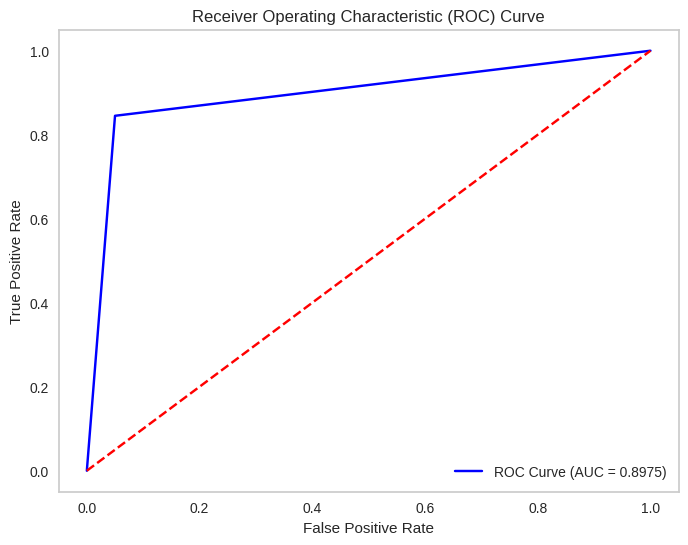

In [ ]:
# ROC AUC 점수 계산
roc_auc = roc_auc_score(y_test, predictions_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ROC Curve 그리기
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# best_model = final_models['CatBoost']
# best_model.fit(X_selected, y_smote)
# predictions = best_model.predict_proba(test_selected)[:, 1]
# submission3 = pd.DataFrame({'passengerid': submission['passengerid'], 'survived': predictions})
# submission3.to_csv('submission3.csv', index=False)

# 최종 베이스 모델들 점수 계산

In [ ]:
# 모델들에 대해 교차 검증 점수를 계산
model_scores = {}

for name, model in final_models.items():
    scores = cross_val_score(model, X_selected, y_smote, cv=10, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    model_scores[name] = mean_score
    print(f'{name} CV Accuracy: {mean_score:.8f}')

In [ ]:
# 모델들에 대해 교차 검증 점수를 계산
model_scores = {}

for name, model in final_models.items():
    scores = cross_val_score(model, X_selected, y_smote, cv=10, scoring='accuracy', n_jobs=-1)
    mean_score = scores.mean()
    model_scores[name] = mean_score
    print(f'{name} CV Accuracy: {mean_score:.8f}')

LogisticRegression CV Accuracy: 0.83186659
RandomForest CV Accuracy: 0.93384249
XGBoost CV Accuracy: 0.86856582
LightGBM CV Accuracy: 0.93652506
CatBoost CV Accuracy: 0.93607463
SVC CV Accuracy: 0.89806014
ExtraTrees CV Accuracy: 0.93250320
AdaBoost CV Accuracy: 0.87975256
HistGradientBoosting CV Accuracy: 0.93608064
GradientBoosting CV Accuracy: 0.93518177


# 보팅

In [ ]:
# 0.9 이상의 점수를 기록한 모델들만 사용
selected_models = {name: model for name, model in final_models.items() if model_scores[name] >= 0.89}
selected_models

{'RandomForest': RandomForestClassifier(max_depth=16, n_estimators=416, random_state=42),
 'LightGBM': LGBMClassifier(learning_rate=0.1895913794121573, num_leaves=87, random_state=42),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x792ae8cac430>,
 'SVC': SVC(C=9.756093869192993, gamma=0.9665838465622774, probability=True,
     random_state=42),
 'ExtraTrees': ExtraTreesClassifier(max_depth=20, n_estimators=340, random_state=42),
 'HistGradientBoosting': HistGradientBoostingClassifier(learning_rate=0.2822496530856283, max_depth=12,
                                random_state=42),
 'GradientBoosting': GradientBoostingClassifier(learning_rate=0.03794685773525468, max_depth=5,
                            n_estimators=479, random_state=42,
                            subsample=0.8514159588246629)}

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
# KFold 설정
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# 선택된 모델들로 하드 보팅 앙상블 생성
if selected_models:
    hard_voting_clf = VotingClassifier(
        estimators=[(name, model) for name, model in selected_models.items()],
        voting='hard'
    )

    # 하드 보팅 앙상블 모델의 교차 검증
    hard_voting_scores = cross_val_score(hard_voting_clf, X_selected, y_smote, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f'Hard Voting CV Accuracy: {hard_voting_scores.mean():.4f}')
else:
    print("No models with CV accuracy >= 0.9 found.")

Hard Voting CV Accuracy: 0.9289


In [ ]:
# 선택된 모델들로 소프트 보팅 앙상블 생성
if selected_models:
    soft_voting_clf = VotingClassifier(
        estimators=[(name, model) for name, model in selected_models.items()],
        voting='soft'
    )

    # 소프트 보팅 앙상블 모델의 교차 검증
    soft_voting_scores = cross_val_score(soft_voting_clf, X_selected, y_smote, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f'Soft Voting CV Accuracy: {soft_voting_scores.mean():.4f}')
else:
    print("No models with CV accuracy >= 0.9 found.")

Soft Voting CV Accuracy: 0.9280


# 스태킹

In [ ]:
# 선택된 모델들로 스태킹 앙상블 생성
if selected_models:
    stacking_clf = StackingClassifier(
        estimators=[(name, model) for name, model in selected_models.items()],
        final_estimator=LogisticRegression(random_state=42)
    )

    # 스태킹 앙상블 모델의 교차 검증
    stacking_scores = cross_val_score(stacking_clf, X_selected, y_smote, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f'Stacking CV Accuracy: {stacking_scores.mean():.4f}')
else:
    print("No models with CV accuracy >= 0.9 found.")

Stacking CV Accuracy: 0.9275


In [ ]:
# 5. 가장 성능이 좋은 모델을 선택하여 최종 학습
if max(hard_voting_scores.mean(), soft_voting_scores.mean(), stacking_scores.mean()) == hard_voting_scores.mean():
    best_model = hard_voting_clf
    print("Best Model: Hard Voting")
elif max(hard_voting_scores.mean(), soft_voting_scores.mean(), stacking_scores.mean()) == soft_voting_scores.mean():
    best_model = soft_voting_clf
    print("Best Model: Soft Voting")
else:
    best_model = stacking_clf
    print("Best Model: Stacking")

Best Model: Hard Voting


In [ ]:
best_model = stacking_clf

# 신

In [ ]:
# 6. 최종 모델 학습 및 테스트 데이터에 예측 수행
best_model.fit(X_selected, y_smote)
final_predictions = best_model.predict(test_selected)

[LightGBM] [Info] Number of positive: 1118, number of negative: 1118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3577
[LightGBM] [Info] Number of data points in the train set: 2236, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [ ]:
# 7. 제출 파일 생성
submission = pd.DataFrame({'passengerid': submission['passengerid'], 'survived': final_predictions})
submission.to_csv('submission.csv', index=False)

In [ ]:
final_predictions2 = best_model.predict(test_selected)

In [ ]:
# 7-1. 제출 파일 생성
submission2 = pd.DataFrame({'passengerid': submission['passengerid'], 'survived': final_predictions2})
submission2.to_csv('submission2.csv', index=False)

In [ ]:
# 7-1. 제출 파일 생성
submission3 = pd.DataFrame({'passengerid': submission['passengerid'], 'survived': final_predictions2})
submission3.to_csv('submission3.csv', index=False)